# json file and folder creation


In [3]:
import os
from keras.models import load_model
from PIL import Image, ImageOps
import numpy as np
import os
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

import sys
import os
import json
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ModuleNotFoundError: No module named 'keras'

In [13]:

# Set the directories containing the folders
source_directories = [
    r"D:\06-05-23\img_class_pranav\Eyewear_References",
    r"D:\06-05-23\img_class_pranav\mixed_references-20230525T121900Z-001\mixed_references"
]

# Check if the destination folder already exists, create it if not
destination_directory = r"D:\06-05-23\img_class_pranav\des"

In [4]:
os.makedirs(destination_directory, exist_ok=True)

# Iterate over the source directories
for source_directory in source_directories:
    # Iterate over the folders in the source directory
    for folder_name in os.listdir(source_directory):
        folder_path = os.path.join(source_directory, folder_name)

        # Check if the item in the directory is a folder
        if os.path.isdir(folder_path):
            # Find the JSON file within the folder
            json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

            # Check if there is exactly one JSON file in the folder
            if len(json_files) == 1:
                json_file_name = json_files[0]
                json_file_path = os.path.join(folder_path, json_file_name)

                # Load and process the JSON file
                with open(json_file_path, encoding = "utf8",errors = "ignore") as json_file:
                    try:
                        json_data = json.load(json_file)
                    except json.JSONDecodeError as e:
                        print(f"Error loading JSON file '{json_file_path}': {str(e)}")
                        continue

                # Access the desired data from the JSON
                product_category = json_data.get("productType")

                # Create folder and name it according to the product category
                if product_category:
                    folder_name_new = product_category.lower().replace(" ", "_")
                else:
                    folder_name_new = "folder_without_category"

                # Create the new folder in the destination directory
                new_folder_path = os.path.join(destination_directory, folder_name_new)
                os.makedirs(new_folder_path, exist_ok=True)

                # copy the contents of the original folder to the new folder
                for file_name in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file_name)
                    new_file_path = os.path.join(new_folder_path, file_name)

                    # Check if a file with the same name already exists in the destination folder
                    if os.path.exists(new_file_path):
                        file_name_base, file_extension = os.path.splitext(file_name)
                        renamed_file_name = f"{file_name_base}_1{file_extension}"
                        renamed_file_path = os.path.join(new_folder_path, renamed_file_name)

                        # Rename the file with a postfix if it already exists
                        shutil.copy(file_path, renamed_file_path)
                    else:
                        shutil.copy(file_path, new_folder_path)

                print(f"Folder '{folder_name}' from '{source_directory}' processed and copied to '{new_folder_path}'.")
            else:
                print(f"Skipping folder '{folder_name}' in '{source_directory}' as it does not contain a single JSON file.")


Folder 'PTRC02BELNZA95EL' from 'D:\06-05-23\img_class_pranav\Eyewear_References' processed and copied to 'D:\06-05-23\img_class_pranav\des\eyewear'.
Folder 'PTRC05FNE979P431' from 'D:\06-05-23\img_class_pranav\Eyewear_References' processed and copied to 'D:\06-05-23\img_class_pranav\des\eyewear'.
Folder 'PTRC0775WWW6G1W9' from 'D:\06-05-23\img_class_pranav\Eyewear_References' processed and copied to 'D:\06-05-23\img_class_pranav\des\eyewear'.
Folder 'PTRC08K4LWTJM1HF' from 'D:\06-05-23\img_class_pranav\Eyewear_References' processed and copied to 'D:\06-05-23\img_class_pranav\des\eyewear'.
Folder 'PTRC0BCB8HNG7HL9' from 'D:\06-05-23\img_class_pranav\Eyewear_References' processed and copied to 'D:\06-05-23\img_class_pranav\des\eyewear'.
Folder 'PTRC0HL02XH1G883' from 'D:\06-05-23\img_class_pranav\Eyewear_References' processed and copied to 'D:\06-05-23\img_class_pranav\des\eyewear'.
Folder 'PTRC0HL3FYNH2BV4' from 'D:\06-05-23\img_class_pranav\Eyewear_References' processed and copied to '

# Classification model


In [5]:


# Set up the directory for your main dataset folder
#dataset_dir = '/content/des'
dataset_dir = destination_directory
# Set the parameters for your model
image_size = (224, 224)  # Size of input images for the model

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Load and preprocess the training dataset
train_images = []
train_labels = []
label_mapping = {}

for i, category_folder in enumerate(os.listdir(dataset_dir)):
    category_path = os.path.join(dataset_dir, category_folder)
    if not os.path.isdir(category_path):  # Skip non-directory files
        continue
    if category_folder == '.ipynb_checkpoints':  # Skip any system-generated folders
        continue
    if category_folder.endswith('.json'):  # Skip JSON files
        continue

    label_mapping[i] = category_folder

    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        if image_name.endswith('.json'):  # Skip JSON files
            continue
        if os.path.isfile(image_path):  # Skip subdirectories and non-file items
            train_images.append(image_path)
            train_labels.append(i)

# Convert labels to categorical format
num_classes = len(label_mapping)
train_labels = keras.utils.to_categorical(train_labels, num_classes)

# Build the model
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_datagen.flow_from_directory(
        dataset_dir,
        target_size=image_size,
        batch_size=64,
        class_mode='categorical',
        shuffle=True
    ),
    epochs=20
)

# Save the model
model.save('my_model_1.h5')

# Print label mapping
print(label_mapping)


Found 5258 images belonging to 51 classes.
Epoch 1/20
77/83 [==========================>...] - ETA: 10s - loss: 6.2709 - accuracy: 0.1758

KeyboardInterrupt: 

# label file creation


In [ ]:
# Load and preprocess the training dataset
label_mapping = {}

for i, category_folder in enumerate(os.listdir(dataset_dir)):
    category_path = os.path.join(dataset_dir, category_folder)
    if not os.path.isdir(category_path):  # Skip non-directory files
        continue
    if category_folder == '.ipynb_checkpoints':  # Skip any system-generated folders
        continue
    if category_folder.endswith('.json'):  # Skip JSON files
        continue

    label_mapping[i] = category_folder

# Generate and save the labels file
labels = [label_mapping[i] for i in range(len(label_mapping))]
labels_file = '/content/labels1.txt'

with open(labels_file, 'w') as file:
    file.write('\n'.join(labels))


# Predition code


1/1 [==============================] - 1s 631ms/step
Predicted Category:  shoes

1/1 [==============================] - 0s 27ms/step


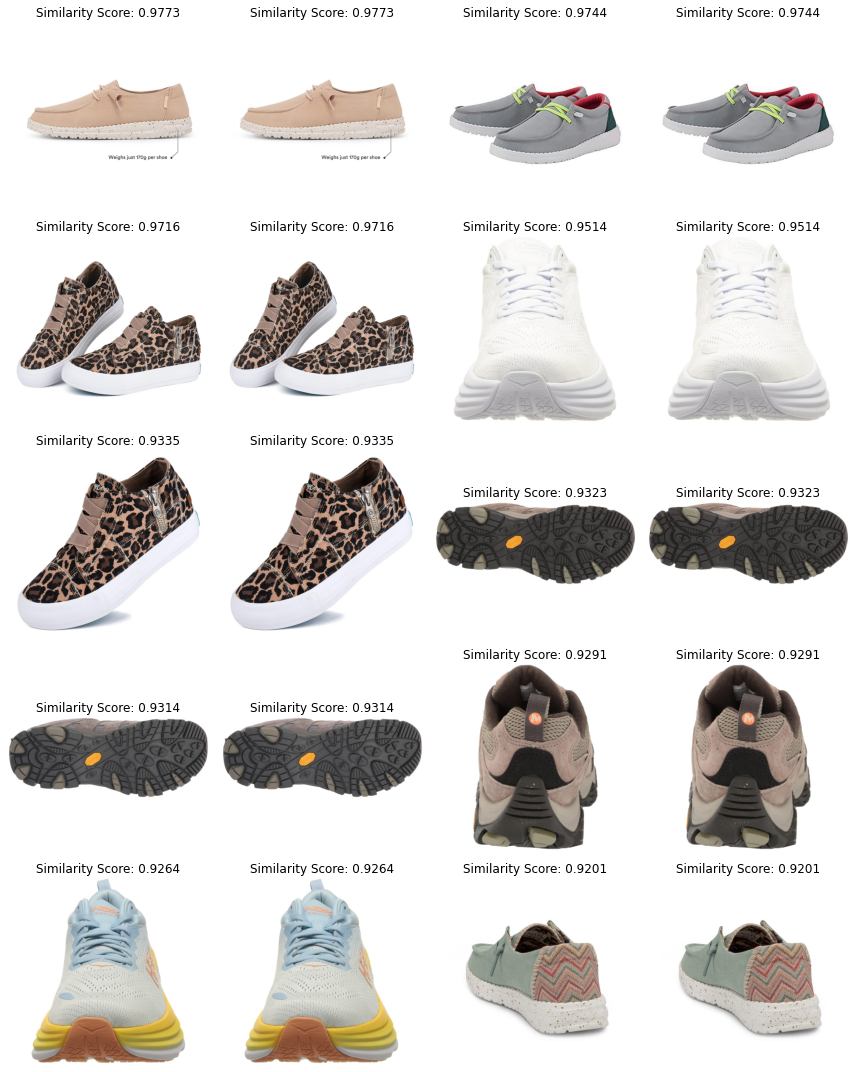

In [29]:

# Take input image from the user
input_image_path = input("Enter the path to the input image: ")
#_____

# model path
model_path = r"C:\Users\ASUS\Desktop\img_class_diksha\keras_model.h5"

labels_path = r"C:\Users\ASUS\Desktop\img_class_diksha\labels.txt"

des_path = f"D:/06-05-23/img_class_pranav/des/"

# Load the pre-trained ResNet50 model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Define functions to preprocess images and extract features
def preprocess_image(image):
    image = image.resize((224, 224))
    image = ImageOps.fit(image, (224, 224))
    image = image.convert("RGB")
    image = np.array(image)
    image = preprocess_input(image)
    return image

def extract_features(image):
    image = preprocess_image(image)
    image = np.expand_dims(image, axis=0)
    features = model.predict(image)
    features = np.reshape(features, (features.shape[0], -1))
    return features

# Define the main function to perform similarity matching
def find_similarity(input_image_path, folder_path):
    # Load the input image
    input_image = Image.open(input_image_path)

    # Extract features from the input image
    input_features = extract_features(input_image)

    folder_features = []
    image_paths = []

    # Loop through the images in the folder
    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            file_path = os.path.join(root, file_name)

            # Exclude non-image files and JSON files
            if not (file_name.lower().endswith('.jpg') or file_name.lower().endswith('.jpeg') or file_name.lower().endswith('.png')):
                continue

            # Load and preprocess each image in the folder
            image = Image.open(file_path)
            features = extract_features(image)

            # Store the features and image paths for later use
            folder_features.append(features)
            image_paths.append(file_path)

    # Convert the lists to numpy arrays
    folder_features = np.concatenate(folder_features)
    image_paths = np.array(image_paths)

    # Compute cosine similarity scores
    similarity_scores = cosine_similarity(input_features, folder_features)

    # Find the indices of the top 20 most similar images
    top_indices = np.argsort(similarity_scores.ravel())[::-1][:20]

    # Get the paths of the top 20 most similar images
    top_image_paths = image_paths[top_indices]
    top_similarity_scores = similarity_scores[0, top_indices]

    return top_image_paths, top_similarity_scores

# Load the model

model = load_model(model_path, compile=False)

# Load the labels

class_names = open(labels_path, "r").readlines()

# Create the array of the right shape to feed into the keras model
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)



# Load the input image
image = Image.open(input_image_path).convert("RGB")

# Resize and normalize the image
size = (224, 224)
image = ImageOps.fit(image, size)
image_array = np.asarray(image)
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1
data[0] = normalized_image_array

# Predict the category of the input image
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]

# Print the predicted category
print("Predicted Category:", class_name[2:])
if(input ("do you wanna add the image in predicted category folder ? (y/n)")=="y"):
  shutil.copy(input_image_path,folder_path)
elif(input("do you want to make new category manually for this image ? (y/n)")=="y"):
  new_category = input("give the name for new category : ")
  # Create the new folder in the destination directory
  new_folder_path = os.path.join(destination_directory, new_category)
  os.makedirs(new_folder_path, exist_ok=True)
  shutil.copy(input_image_path,new_folder_path)
  sys.exit("your new folder has been appended")



# Select the folder based on the predicted category
folder_path =  des_path + class_name[3:-1]+"/"

# Perform similarity matching
top_image_paths, top_similarity_scores = find_similarity(input_image_path, folder_path)

# Load the input image
input_image = Image.open(input_image_path)

# Plot the input image and the top 20 similar images
fig, axes = plt.subplots(5, 4, figsize=(12, 15))
axes = axes.ravel()

for i, (image_path, similarity_score) in enumerate(zip(top_image_paths, top_similarity_scores)):
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Similarity Score: {similarity_score:.4f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#check the paths and directories | if any error occured like "ValueError: need at least one array to concatenate " then check for the paths in prediction code there might be some string slicing mistake.


In [28]:
des_path = f"D:/06-05-23/img_class_pranav/des/"
folder_path = des_path + class_name[3:-1]+"/"
folder_path

'D:/06-05-23/img_class_pranav/des/sofas/'

In [17]:
print("Predicted Category:", class_name[2:])

Predicted Category:  workbench



In [ ]:
print("Predicted Category:", class_name[3:])
if(input ("do you wanna add the image in predicted category folder ? (y/n)")=="y"):
  shutil.copy(input_image_path,folder_path)

Predicted Category: sunglasses

do you wanna add the image in predicted category folder ? (y/n)n
